In [22]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm import tqdm
%matplotlib inline

# Extend PATH Variable
import sys
sys.path.append("src/")

# NanoNets Simulation Tool
import nanonets
import nanonets_utils

# Plot Colors
blue_color  = '#348ABD'
red_color   = '#A60628'

## Step 1:
### Init Network Topology and Electrostatic Properties:
- Network Topology either `"cubic"` or `"random"`
- `topology_parameter` defines network parameter via the following keys
- if `"cubic"`
    - `"Nx"`    :   Number of Nanoparticles in x-direction
    - `"Ny"`    :   Number of Nanoparticles in y-direction
    - `"Nz"`    :   Number of Nanoparticles in z-direction
    - `"e_pos"` :   Electrode positions as list of lists. Each element corresponds to nanoparticle position `[x,y,z]` which is attached to an electrode

- if `"random"`
    - `$N_{NP}$`    :   Number of Nanoparticles
    - `$N_{J}$`     :   Number of Junctions per Nanoparticle
    - `"e_pos"`     :   Electrode positions as list of lists. Each element corresponds to cartesian coordinates `[x,y]` of the specific electrode. Closest nanoparticle to this electrode will be attached to it

- `np_info` defines electrostatic properies via nanoparticle properties
    - `"eps_r"`         : relative permittivity of the insulating molecule
    - `"eps_s"`         : relative permittivity of the insulating SiO2 layer
    - `"mean_radius"`   : average nanoparticle radius [nm]
    - `"std_radius"`    : standard deviation nanopartcile radius [nm]  
    - `"np_distance"`   : spacing in between nanoparticles

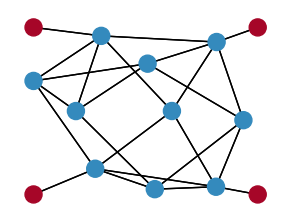

In [23]:
# Example: Random Network
network_topology = "random"

# Network Parameter
topology_parameter  = {
    "Np"    : 10,
    "Nj"    : 4,
    "e_pos" : [[-1,-1],[-1,1],[1,-1],[1,1]]
}

# Nanoparticle Parameter
np_info = {
    "eps_r"         : 2.6,
    "eps_s"         : 3.9,
    "mean_radius"   : 10.0,
    "std_radius"    : 0.0,
    "np_distance"   : 1.0
}

# Nanoparticle Resistances
# res_info = {
#     "mean_R"    : 25.0,
#     "std_R"     : 0.0
# }
res_info = {
    "mean_R"    : 25.0,
    "std_R"     : 0.0,
    "dynamic"   : True,
    'slope'     : 0.8,
    'shift'     : 7.5,
    'tau_0'     : 1e-9,
    'R_max'     : 25,
    'R_min'     : 10
}

# Save Folder
folder  = ""

# Network Class Object
np_network_random = nanonets.simulation(network_topology=network_topology, topology_parameter=topology_parameter, folder=folder, np_info=np_info, res_info=res_info)

# Plot Network (blue : NP - red : Electrode)
fig, ax = nanonets_utils.display_network(np_network_sim=np_network_random, node_size=150)

## Step 2:
### Define Electrode Voltages
- Voltages are either constant in time or not
- In either case we need as many electrode voltages as there are electrodes connected to the network, otherwise --> Error
- Voltages are defined via an array
    - with columns corresponding to the electrode. First Column == First Electrode at position `topology_parameter['epos'][0]`
    - the last column corresponds to the gate electrode, which is electrostatic coupled to all nanopartciles, i.e. there **have to be** `N_electrodes + 1` in the voltage numpy array 
    - rows correspond either to the set of constant electrode voltages or to the voltage time series (first row = t0, second row = t1, ...)
    - most of the time there is an electrode referred as *output* which is generally grounded, i.e. $U = 0 V$
- In case of time dependent voltages one must also define a time scale as a simple 1D array

In [24]:
# Time Scale
step_size       = 1e-10
N_voltages      = 1000
time            = step_size*np.arange(N_voltages)
v1              = np.cos(time*5e8)
v2              = np.cos(time*5e8-np.pi/4)
voltages_time   = np.zeros(shape=(N_voltages,np_network_random.N_electrodes+1))

# Input Electrode
voltages_time[:,0]              = 0.1*np.cos(time*1e9)
voltages_time[:,1]              = 0.1*np.cos(time*5e8-np.pi/4)
voltages_time[:,2]              = -0.02

print(voltages_time)

[[ 0.1         0.07071068 -0.02        0.          0.        ]
 [ 0.09950042  0.07415637 -0.02        0.          0.        ]
 [ 0.09800666  0.07741671 -0.02        0.          0.        ]
 ...
 [ 0.06741634  0.03615368 -0.02        0.          0.        ]
 [ 0.07445306  0.04076835 -0.02        0.          0.        ]
 [ 0.08074587  0.04528111 -0.02        0.          0.        ]]


## Step 3:
### Run Simulation
- For const voltages `run_const_voltages()` and time dependent voltages `run_var_voltages()`
- `run_const_voltages()` arguments:
    - voltages          :   s.o
    - target_electrode  :   index of output electrode most of the time `N_electrodes - 1`
    - T_val             : Temperature
    - sim_dic           : dictonary containing information for simulation with keys
        - error_th  : desired relative error
        - max_jumps : maximum number of MC steps
        - eq_steps  : number of equilibration steps before production run
    - save_th   :   save results at each save_th step. If values should not be stored just choose save_th < 1
- `run_var_voltages()` arguments:
    - voltages          : s.o
    - time_steps        : s.o
    - target_electrode  : index of output electrode most of the time `N_electrodes - 1`
    - eq_steps          : number of equilibration steps before time starts
    - T_val             : Temperature
    - save_th           : save results at each save_th step.  If values should not be stored just choose save_th < 1
    - store_per_it_min  : at this time start to store all potential/charge distributions
    - store_per_it_max  : at this time stop to store all potential/charge distributions
    - init              : initialize the system or move on from current state

In [25]:
# Example: Time dependent Voltage Simulation
target_electrode    = np_network_random.N_electrodes - 1
outputs             = []
resistances         = []
stat_size           = 50

for _ in tqdm(range(stat_size)):
    
    np_network_random.clear_outputs()
    np_network_random.run_var_voltages(voltages=voltages_time, time_steps=time, target_electrode=target_electrode, save_th=0.1, eq_steps=10000)
    outputs.append(np_network_random.return_output_values())
    resistances.append(np_network_random.resistance_mean)

time_outpus         = pd.DataFrame(np.hstack([voltages_time[:-1,:],np.mean(outputs,axis=0)]))
time_outpus.columns = [f"U_{i}" for i in range(np_network_random.N_electrodes)] + ["U_G", "eq_steps", "product_steps", "I", "u_I"]
time_outpus['u_I']  = np.std(outputs, axis=0)[:,-2]/np.sqrt(stat_size)
time_outpus

100%|██████████| 50/50 [00:03<00:00, 15.73it/s]


,U_0,U_1,U_2,U_3,U_G,eq_steps,product_steps,I,u_I
0,0.100000,0.070711,-0.02,0.0,0.0,10000.0,9.40,669.791291,53.989121
1,0.099500,0.074156,-0.02,0.0,0.0,10000.0,8.70,620.776529,44.565726
2,0.098007,0.077417,-0.02,0.0,0.0,10000.0,8.62,573.633432,46.033822
3,0.095534,0.080484,-0.02,0.0,0.0,10000.0,8.20,522.568550,45.243504
4,0.092106,0.083349,-0.02,0.0,0.0,10000.0,8.38,513.790542,44.908718
...,...,...,...,...,...,...,...,...,...
994,0.042579,0.021815,-0.02,0.0,0.0,10000.0,2.42,-90.465001,29.371175
995,0.051399,0.026665,-0.02,0.0,0.0,10000.0,2.22,-64.272214,24.821998
996,0.059706,0.031449,-0.02,0.0,0.0,10000.0,3.12,-51.752291,17.537888
997,0.067416,0.036154,-0.02,0.0,0.0,10000.0,3.86,-12.849076,13.678485


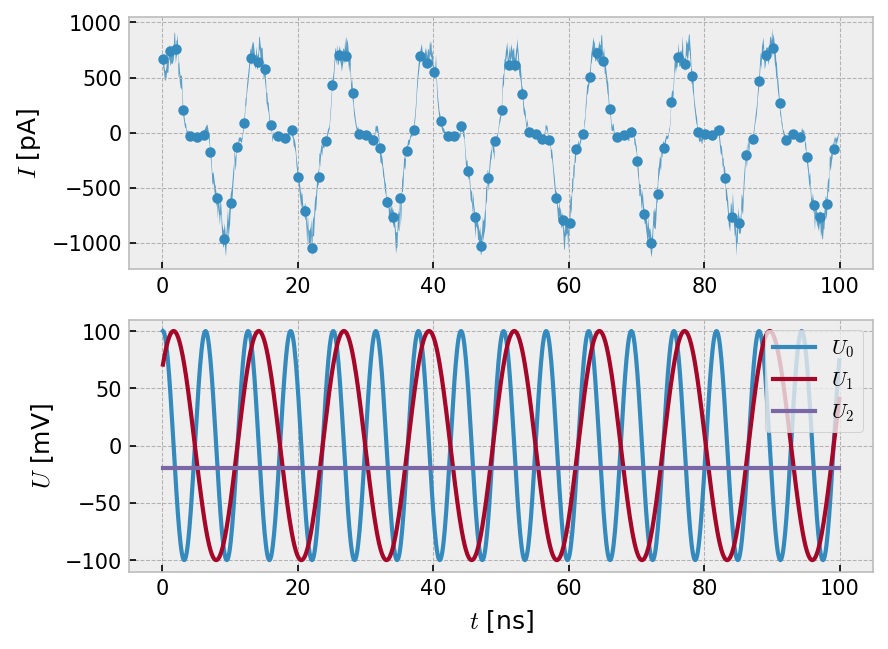

In [26]:
with plt.style.context("bmh"):

    fig = plt.figure(dpi=150)
    ax  = fig.add_subplot(2,1,1)
    ax.plot(time[1:]*10**9, time_outpus['I'], 'o', markevery=10, ms=4)
    ax.fill_between(time[1:]*10**9, time_outpus['I']-time_outpus['u_I'], time_outpus['I']+time_outpus['u_I'], alpha=0.8)
    ax.set_ylabel("$I$ [pA]")
    
    ax  = fig.add_subplot(2,1,2)
    ax.plot(time[1:]*10**9, time_outpus['U_0']*1000, label='$U_0$')
    ax.plot(time[1:]*10**9, time_outpus['U_1']*1000, label='$U_1$')
    ax.plot(time[1:]*10**9, time_outpus['U_2']*1000, label='$U_2$')
    ax.set_xlabel("$t$ [ns]")
    ax.set_ylabel("$U$ [mV]")
    ax.legend()

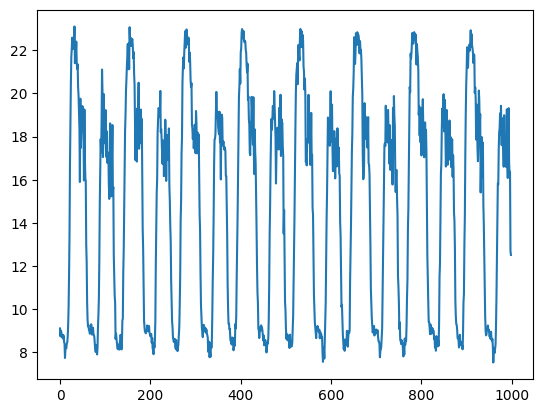

In [28]:
ele_charge  = 0.160217662
r_vals      = np.array(np.mean(resistances,axis=0))[:,0]
r_vals      = r_vals*1e12/(ele_charge*ele_charge)

plt.plot(r_vals)
# plt.xlim(0,100)

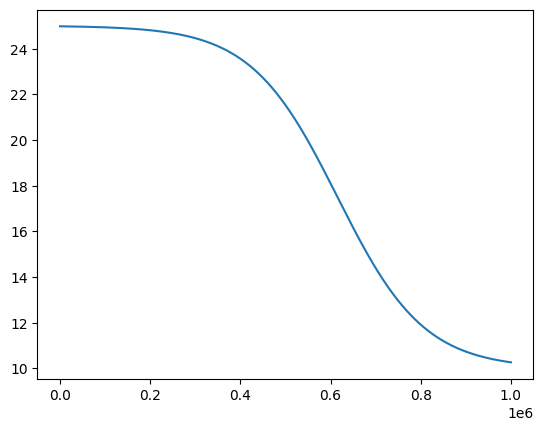

In [15]:
plt.plot((25 - 10)*(-np.tanh(0.8*(np.linspace(3.5,10,1000000) - 7.5)) + 1)/2 + 10)

In [19]:
np.array(np_network_random.resistance_mean)[:,0] == 0

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False,  True, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

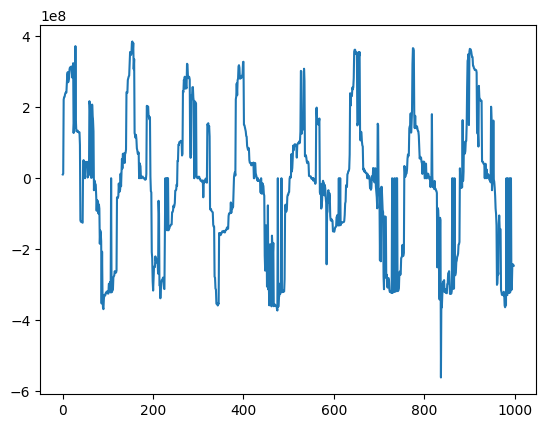

In [54]:
plt.plot(np_network_random.return_potential_landscape()[:,9])

In [ ]:
store_per_it_min    = 12e-6
store_per_it_max    = 14e-6
simulation_outputs  = run_simulation(voltages=voltages, time_steps=time_steps, target_electrode=N_electrodes-1,
                    network_topology=network_topology, topology_parameter=topology_parameter,
                    R=25.0, Rstd=5.0, store_per_it_min=store_per_it_min, store_per_it_max=store_per_it_max, start_val=start_val)

In [ ]:
output_values               = pd.concat([pd.DataFrame(np.mean(simulation_outputs['output'],axis=0)),pd.DataFrame(np.std(simulation_outputs['output'],axis=0))/np.sqrt(len(simulation_outputs['output']))],axis=1)
output_values.columns       = ["Jumps","Current","Jumps_Error","Current_Error"] 
microstate                  = pd.DataFrame(np.mean(simulation_outputs["microstate"],axis=0))
microstate_error            = pd.DataFrame(np.std(simulation_outputs["microstate"],axis=0))/np.sqrt(len(simulation_outputs["microstate"]))
landscape                   = 1000*pd.DataFrame(np.mean(simulation_outputs["landscape"],axis=0))
landscape_error             = 1000*pd.DataFrame(np.std(simulation_outputs["landscape"],axis=0))/np.sqrt(len(simulation_outputs["landscape"]))
net_currents                = pd.DataFrame(np.mean(simulation_outputs["net_currents"],axis=0))
net_currents.columns        = simulation_outputs["net_currents"][0].columns
net_currents_error          = pd.DataFrame(np.std(simulation_outputs["net_currents"],axis=0))/np.sqrt(len(simulation_outputs["net_currents"]))
net_currents_error.columns  = simulation_outputs["net_currents"][0].columns

In [ ]:
print(f"Average Jumps per Step: {np.round(output_values['Jumps'].mean(),2)}")

### Output electric Current

In [ ]:
normed_input    = (inputs - np.min(inputs))/(np.max(inputs)-np.min(inputs))
normed_output   = (output_values['Current'] - np.min(output_values['Current']))/(np.max(output_values['Current'])-np.min(output_values['Current']))

with plt.style.context("bmh"):

    fig = plt.figure()
    fig.set_figwidth(fig.get_figwidth()*3)
    fig.set_figheight(fig.get_figheight())
    ax  = fig.add_subplot()
    ax.plot(time, normed_input, '.-', label="Input")
    ax.plot(time, normed_output, '.-', label="Output")
    # ax.fill_between(x=time, y1=(output_values['Current']-output_values['Current_Error']), y2=(output_values['Current']+output_values['Current_Error']), alpha=0.8)
    # ax.plot(time, inputs, '.-', label="Input")
    ax.set_xlabel("$t$ [$\mu s$]")
    ax.set_ylabel("Signal")
    ax.legend()
    ax.set_xlim(6,9)
    
plt.show()

In [ ]:
with plt.style.context("bmh"):

    fig = plt.figure()
    ax  = fig.add_subplot()
    ax.plot(inputs, output_values['Current'], '.', label="Output")
    # ax.plot(time, inputs, '.-', label="Input")
    ax.set_xlabel("$U_{I}$ $[mV]$")
    ax.set_ylabel("$I_O$ $[nA]$")
    ax.legend()


In [ ]:
plt.rcParams["animation.html"] = "jshtml"
from IPython.display import HTML

In [ ]:
output_values['Current']

In [ ]:
with plt.style.context("bmh"):

    fig, ax = plt.subplots()
    ax.set_xlim(-300,300)
    ax.set_ylim(-10,10)

    scat = ax.scatter(inputs[0],output_values['Current'][0])

    def animate(i):
        scat.set_offsets((inputs[i],output_values['Current'][i]))
        return scat,

    ani = animation.FuncAnimation(fig, animate, repeat=True,
                                        frames=1000, interval=1)

ani.save("test.gif")

#### Micro State

In [ ]:
np_index = 24

with plt.style.context("bmh"):

    fig = plt.figure()
    ax  = fig.add_subplot()
    ax.plot(time, microstate[np_index], '.-')
    ax.fill_between(x=time, y1=(microstate[np_index]-microstate_error[np_index]), y2=(microstate[np_index]+microstate_error[np_index]), alpha=0.8)
    ax.set_xlabel("$t$ [$\mu s$]")
    ax.set_ylabel("$n_{"+f"{np_index}"+"}$ [e]")
    # ax.set_xscale('log')
    plt.show()

### Estimate electric Potential at Output Electrode

In [1]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm import tqdm
%matplotlib inline

# Extend PATH Variable
import sys
sys.path.append("src/")

# NanoNets Simulation Tool
import nanonets
import nanonets_utils

# Plot Colors
blue_color  = '#348ABD'
red_color   = '#A60628'

(<Figure size 350x262.5 with 1 Axes>, <AxesSubplot: >)

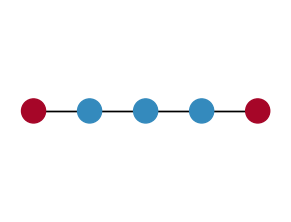

In [2]:
# Example: Cubic Network
network_topology = "cubic"

# Network Parameter
topology_parameter = {
    "Nx"    : 3,
    "Ny"    : 1,
    "Nz"    : 1,
    "e_pos" : [[0,0,0],[2,0,0]]
}

# Network Class Object
np_network_cubic = nanonets.simulation(network_topology=network_topology, topology_parameter=topology_parameter)
nanonets_utils.display_network(np_network_cubic)

In [3]:
N_voltages      = 101
voltages        = np.zeros(shape=(N_voltages,3))
voltages[:,0]   = np.linspace(-0.1,0.1,N_voltages,endpoint=True)

np_network_cubic = nanonets.simulation(network_topology=network_topology, topology_parameter=topology_parameter)
np_network_cubic.run_const_voltages(voltages=voltages, target_electrode=1, save_th=0.1, jumps_per_stat=100, output_potential=True)

df = pd.DataFrame(np.hstack((voltages,np_network_cubic.return_output_values())))
df.plot(0,5)

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


KeyboardInterrupt: 

<AxesSubplot: xlabel='0'>

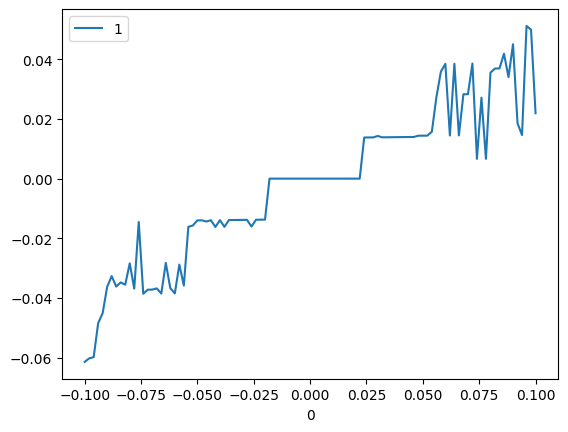

In [ ]:
df = pd.DataFrame(np_network_cubic.return_potential_landscape())
df.plot(x=0, y=1)

<AxesSubplot: xlabel='0'>

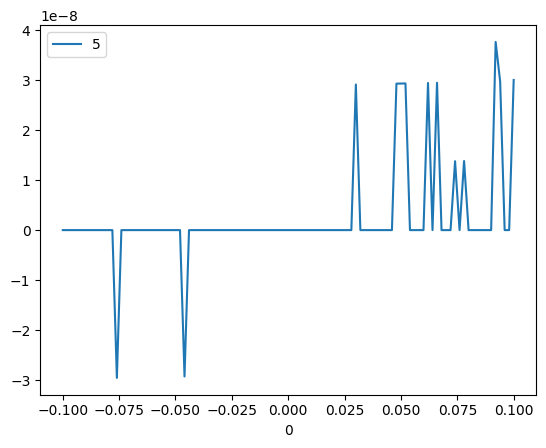

In [ ]:
df = pd.DataFrame(np.hstack((voltages,np_network_cubic.return_output_values())))
df.plot(0,5)

#### NP Potential

In [ ]:
np_index = 24

with plt.style.context("bmh"):

    fig = plt.figure()
    ax  = fig.add_subplot()
    ax.plot(time, landscape[np_index], '.-')
    ax.fill_between(x=time, y1=(landscape[np_index]-landscape_error[np_index]), y2=(landscape[np_index]+landscape_error[np_index]), alpha=0.8)
    ax.set_xlabel("$t$ [$\mu s$]")
    ax.set_ylabel("$U_{"+f"{np_index}"+"}$ [mV]")
    # ax.set_xscale('log')
    plt.show()

### Potential and Jumps Evolution

In [ ]:
def return_auto_corr(time, arr, n_lags=20):

    time    = time - np.min(time)
    time    = time[:n_lags]
    a_c     = [1. if t==0 else np.corrcoef(arr[:-t],arr[t:])[0,1] for t in range(n_lags)]

    return time, a_c

def collect_auto_corr(time_evo, arr, t_range, n_stats=50, n_lags=20):

    corr    = pd.DataFrame()

    for i in range(n_stats):

        try:
            t, a_c  = return_auto_corr(time_evo[i], arr[i], n_lags=n_lags)
            func    = interp1d(t, a_c)

            corr[i] = func(t_range)
        except:
            pass
    
    return corr

In [ ]:
np_index        = 24
n_run           = 0
stored_indices  = np.where((time_steps >= store_per_it_min) & (time_steps < store_per_it_max))[0]
potential_evo   = [simulation_outputs["network_classes"][n_run].return_pot_per_it()[i][1:,np_index] for i in stored_indices]
time_evo        = [simulation_outputs["network_classes"][n_run].return_time_vals()[i][1:]*10**9 for i in stored_indices]

In [ ]:
def jump_diff(np_index, connected_nps):

    abgänge = []

    for i_np in connected_nps:

        jump_index      = np.where(net_currents.columns == (np_index,i_np))[0][0]
        jumps_evo       = [simulation_outputs["network_classes"][n_run].return_jumps_per_it()[i][1:,jump_index] for i in stored_indices]
        jumps_evo       = [np.insert((jumps_evo[i][1:] - jumps_evo[i][0:-1]),0,0) for i in range(len(stored_indices))]
        abgänge.append(jumps_evo)

    zugänge = []

    for i_np in connected_nps:

        jump_index      = np.where(net_currents.columns == (i_np,np_index))[0][0]
        jumps_evo       = [simulation_outputs["network_classes"][n_run].return_jumps_per_it()[i][1:,jump_index] for i in stored_indices]
        jumps_evo       = [np.insert((jumps_evo[i][1:] - jumps_evo[i][0:-1]),0,0) for i in range(len(stored_indices))]
        zugänge.append(jumps_evo)
    
    return np.sum(zugänge,axis=0) - np.sum(abgänge,axis=0)

jump_zu_ab = jump_diff(26, [1,21,25])

In [ ]:
t_range_pot     = np.linspace(0,0.15,100)
t_range_jump    = np.linspace(0,0.15,100)
pot_auto_corr   = collect_auto_corr(time_evo, potential_evo, t_range_pot)
jump_auto_corr  = collect_auto_corr(time_evo, jump_zu_ab, t_range_jump)

In [ ]:
y_pot   = pot_auto_corr.mean(axis=1)
y_jump  = jump_auto_corr.mean(axis=1)

y1_pot  = y_pot - pot_auto_corr.std(axis=1)/np.sqrt(len(pot_auto_corr.columns))
y2_pot  = y_pot + pot_auto_corr.std(axis=1)/np.sqrt(len(pot_auto_corr.columns))

y1_jump = y_jump - jump_auto_corr.std(axis=1)/np.sqrt(len(jump_auto_corr.columns))
y2_jump = y_jump + jump_auto_corr.std(axis=1)/np.sqrt(len(jump_auto_corr.columns))

with plt.style.context("bmh"):
    
    fig = plt.figure()
    ax  = fig.add_subplot()

    for i in range(20):

        ax.plot(t_range_pot, y_pot, '.-', c=blue_color, label='$U_{NP}$')
        ax.fill_between(t_range_pot, y1_pot, y2_pot, color=blue_color, alpha=0.01)

        ax.plot(t_range_jump, y_jump, '.-', c=red_color, label='$J_{+}-J_{-}$')
        ax.fill_between(t_range_jump, y1_jump, y2_jump, color=red_color, alpha=0.01)

        if i == 0:
            ax.legend()

    ax.set_ylabel("$corr[y(t),y(t-1)]$")
    ax.set_xlabel("$t$ $[ns]$")

plt.show()